In [1]:
# Authors: David Moiraf, david.moiraf@cea.fr
# Authors: Magne Lauritzen, mag.lauritzen@gmail.com

# -- use this line at the beginning of your notebook to turn on interactive plots
# %matplotlib notebook
%matplotlib widget

# Imports
import sys
import matplotlib.pyplot as plt  # plotting library
from matplotlib import colors
import numpy as np  # work with numeric arrays without labeled axes
import xarray as xr  # work with arrays with labeled axes
import xrscipy.signal as dsp  # xarray signal filtering etc.
import scipy as sps
from cdb_extras import xarray_support as cdbxr  # access to COMPASS Database (CDB)
import pickle # to save data
from pathlib import Path # to easily work with different files
from progressbar import ProgressBar
import pandas as pd

import seaborn as sns

from core.sawtooth_extraction import ST_detector, ST_time_and_phase, ST_detector_plot
from core.pedestal_ploting import load_pedestal_data, scatter_pedestal_params, get_ELM_ST_phase_and_duration, scatter_pedestal_params_4plots, get_elm_length_and_time
from core.analysis import scatter_hist, load_ST_crash_time
from core.ELM_extraction import ELM_phase



psi_n_lim = 0.6
savesaw="/compass/home/odlozilik/repos/ELM-Sawtooth/sawtooth_data"
saveped="/compass/home/odlozilik/repos/ELM-Sawtooth/shots_pedestals"

Matplotlib is building the font cache; this may take a moment.


In [2]:
pedestal_data_folder = Path('./shots_pedestals')
pedestal_data_list = []

for item in pedestal_data_folder.iterdir():
    if item.is_file and item.suffix == ".bin":
        with open(item, 'rb') as fp:
            pedestal_data_list.append(pickle.load(fp))

In [149]:
# ELM analysis:

# RMP_tot=np.empty(0)

ELM_ST_phase_tot=np.empty(0)
ELM_ST_time_tot=np.empty(0)
ELM_duration_tot=np.empty(0)

triangularity_val=np.empty(0)
I_p_ELM=np.empty(0)
n_ELM=np.empty(0)
NBI_ELM=np.empty(0)


for i, d in enumerate(pedestal_data_list):

    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)

    # Filters
    shot = cdbxr.Shot(d.shot_number)
    t_ELM_start = shot['t_ELM_start']


    mask1 = np.logical_and(0. < ELM_duration, ELM_duration < 4)
    mask2 = np.logical_and(mask1, t_ELM_start[1:] < 1200)


    # RMP1=shot(name="RMP_PS_1_Rogowski_coil_RAW")
    # RMP2=shot(name="RMP_PS_2_Rogowski_coil_RAW")
    # RMP=(abs(RMP1)+abs(RMP2))/2

    triang_closest_times = t_ELM_start[:-1]

    tria_values1 = shot(name="triangularity_lower_lcfs")
    tria_values2 = shot(name="triangularity_upper_lcfs")
    triangularity = (tria_values1+tria_values2)/2
    #triang_closest_times_ints = triang_closest_times.astype(int)

    interpolated_tria_values = triangularity.interp(time=t_ELM_start[:-1])
    
    # interpolated_RMP_tot = RMP.interp(time=t_ELM_start)

    I_p_val=shot(name="I_plasma_Rogowski_coil_RAW")
    interpolated_I_p_val = I_p_val.interp(time=t_ELM_start[:-1])

    NBI_nan = np.full_like(ELM_ST_phase, np.nan)*0
    try:
        NBI1_I=shot(name="NBI1_Ibeam")
        NBI1_U=shot(name="NBI1_Ubeam")
        interpolated_NBI1I_val = NBI1_I.interp(time=t_ELM_start[:-1])
        interpolated_NBI1U_val = NBI1_U.interp(time=t_ELM_start[:-1])
        NBI1_val=interpolated_NBI1I_val*interpolated_NBI1U_val
        if np.max(interpolated_NBI1I_val)<1.5:
            NBI1_val = NBI1_val*0
        
    
        NBI2_I=shot(name="NBI2_Ibeam")
        NBI2_U=shot(name="NBI2_Ubeam")
        interpolated_NBI2I_val = NBI2_I.interp(time=t_ELM_start[:-1])
        interpolated_NBI2U_val = NBI2_U.interp(time=t_ELM_start[:-1])
        NBI2_val=interpolated_NBI2I_val*interpolated_NBI2U_val

        if np.max(interpolated_NBI2I_val)<1.5:
             NBI2_val = NBI1_val*0        

        NBI_val=NBI2_val+NBI1_val
        NBI_ELM = np.concatenate((NBI_ELM, NBI_val.to_numpy()[mask2]))
    except Exception as e:
        NBI_ELM = np.concatenate((NBI_ELM, NBI_nan[mask2]))

    n_val=shot(name="MARTE_NODE.PositionDataCollection2.CorrectedDensity")
    interpolated_n_val = n_val.interp(time=t_ELM_start[:-1])
    

    # RMP_tot = np.concatenate((RMP_tot,  interpolated_RMP_tot.to_numpy()[mask2]))
    ELM_ST_phase_tot = np.concatenate((ELM_ST_phase_tot, ELM_ST_phase[mask2]))
    ELM_ST_time_tot = np.concatenate((ELM_ST_time_tot, ELM_ST_time[mask2]))
    ELM_duration_tot = np.concatenate((ELM_duration_tot, ELM_duration[mask2]))
    triangularity_val = np.concatenate((triangularity_val, interpolated_tria_values.to_numpy()[mask2]))
    I_p_ELM = np.concatenate((I_p_ELM, interpolated_I_p_val.to_numpy()[mask2]))
    n_ELM = np.concatenate((n_ELM, interpolated_n_val.to_numpy()[mask2]))


    


2023-12-15 14:13:22,858 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:24,403 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:27,532 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:29,006 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:30,501 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:31,163 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:32,644 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:33,318 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:33,975 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:34,805 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:35,438 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:36,924 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:38,411 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:39,090 - pyCDB       : ERROR    signal not found
2023-12-15 14:13:41,426 - pyCDB       : ERROR    signal not found
2023-12-15

In [43]:
interpolated_NBI_val.shape

(14999,)

In [157]:
# ST analysis:

#load the data
# RMP_tot_ST=np.empty(0)

triangularity_val_ST=np.empty(0)
I_p_ST=np.empty(0)
n_ST=np.empty(0)
NBI_ST=np.empty(0)

ST_relative_to_nearest_ELM_phase_tot=np.empty(0)
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)


for i, d in enumerate(pedestal_data_list):
    # Filters
    shot = cdbxr.Shot(d.shot_number)
    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=False)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]
    ST_relative_to_nearest_ELM_phase=ST_relative_to_nearest_ELM_phase[1:]

    # RMP1=shot(name="RMP_PS_1_Rogowski_coil_RAW")
    # RMP2=shot(name="RMP_PS_2_Rogowski_coil_RAW")
    # RMP=(abs(RMP1)+abs(RMP2))/2
    
    triang_closest_times = ST_times[:-1]
    tria_values1 = shot(name="triangularity_lower_lcfs")
    tria_values2 = shot(name="triangularity_upper_lcfs")
    interpolated_tria_values1 = tria_values1.interp(time=ST_times[1:])
    interpolated_tria_values2 = tria_values2.interp(time=ST_times[1:])

    triangularity = (interpolated_tria_values1+interpolated_tria_values2)/2


    I_p_val=shot(name="I_plasma_Rogowski_coil_RAW")
    interpolated_I_p_val = I_p_val.interp(time=ST_times[:-1])

    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)

    n_val=shot(name="MARTE_NODE.PositionDataCollection2.CorrectedDensity")
    interpolated_n_val = n_val.interp(time=ST_times[:-1])
    NBI_nan = np.full_like(ST_time_relative_to_ELM, np.nan)*0
    try:
        NBI1_I=shot(name="NBI1_Ibeam")
        NBI1_U=shot(name="NBI1_Ubeam")
        interpolated_NBI1I_val = NBI1_I.interp(time=ST_times[:-1])
        interpolated_NBI1U_val = NBI1_U.interp(time=ST_times[:-1])
        NBI1_val=interpolated_NBI1I_val*interpolated_NBI1U_val
        if np.max(interpolated_NBI1I_val)<1.5:
            NBI1_val = NBI1_val*0
        
    
        NBI2_I=shot(name="NBI2_Ibeam")
        NBI2_U=shot(name="NBI2_Ubeam")
        interpolated_NBI2I_val = NBI2_I.interp(time=ST_times[:-1])
        interpolated_NBI2U_val = NBI2_U.interp(time=ST_times[:-1])
        NBI2_val=interpolated_NBI2I_val*interpolated_NBI2U_val

        if np.max(interpolated_NBI2I_val)<1.5:
            NBI2_val = NBI1_val*0        

        NBI_val=NBI2_val+NBI1_val
        NBI_ST = np.concatenate((NBI_ST, NBI_val.to_numpy()[mask1]))
    except Exception as e:
        NBI_ST = np.concatenate((NBI_ST, NBI_nan[mask1]))




    # interpolated_RMP_tot = RMP.interp(time=triang_closest_times_ints)


    #RMP_tot_ST = np.concatenate((RMP_tot_ST,  interpolated_RMP_tot.to_numpy()[mask1]))
    triangularity_val_ST = np.concatenate((triangularity_val_ST, triangularity.to_numpy()[mask1]))

    ST_relative_to_nearest_ELM_phase_tot=np.concatenate((ST_relative_to_nearest_ELM_phase_tot, ST_relative_to_nearest_ELM_phase[mask1]))
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))
    I_p_ST = np.concatenate((I_p_ST, interpolated_I_p_val.to_numpy()[mask1]))
    n_ST = np.concatenate((n_ST, interpolated_n_val.to_numpy()[mask1]))

    


2023-12-15 14:21:04,131 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:05,734 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:08,868 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:10,435 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:12,150 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:12,808 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:14,371 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:15,026 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:15,704 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:16,474 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:17,180 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:18,748 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:20,321 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:20,955 - pyCDB       : ERROR    signal not found
2023-12-15 14:21:23,480 - pyCDB       : ERROR    signal not found
2023-12-15

In [29]:
has_non_nan = np.any(~np.isnan(NBI_ELM))
if has_non_nan:
    print("The array has non-NaN values.")
else:
    print("The array only contains NaN values.")

The array only contains NaN values.


In [158]:
# Assuming you have ndarrays a, b, c, d, e
# Replace these with your actual data
a = ST_time_relative_to_ELM_tot
b = ST_periods_tot
d = triangularity_val_ST
e= I_p_ST
f= n_ST
g= NBI_ST

#e = RMP_tot_STELM_ST_phase

# Create a DataFrame from the arrays}
data = {'$T_{ST}$ [ms]': b, '$t_{ST}$ relative to previous ELM [ms]': a, '$\dfrac{\delta_u+\delta_l}{2}$': d,'$I_p$': e, '$n$': f,'$NBI1+NBI2$': g  }
df = pd.DataFrame(data)

In [163]:
# Assuming you have ndarrays a, b, c, d, e
# Replace these with your actual data
a = ELM_duration_tot
b = ELM_ST_time_tot
d = triangularity_val
e= I_p_ELM
f= n_ELM
g= NBI_ELM

#e = RMP_tot

# Create a DataFrame from the arrays
data = {'$T_{ELM}$ [ms]': a, '$t_{ELM}$ relative to previous ST [ms]': b, '$\dfrac{\delta_u+\delta_l}{2}$': d,'$I_p$': e, '$n$': f,'$NBI1+NBI2$': g }
df = pd.DataFrame(data)

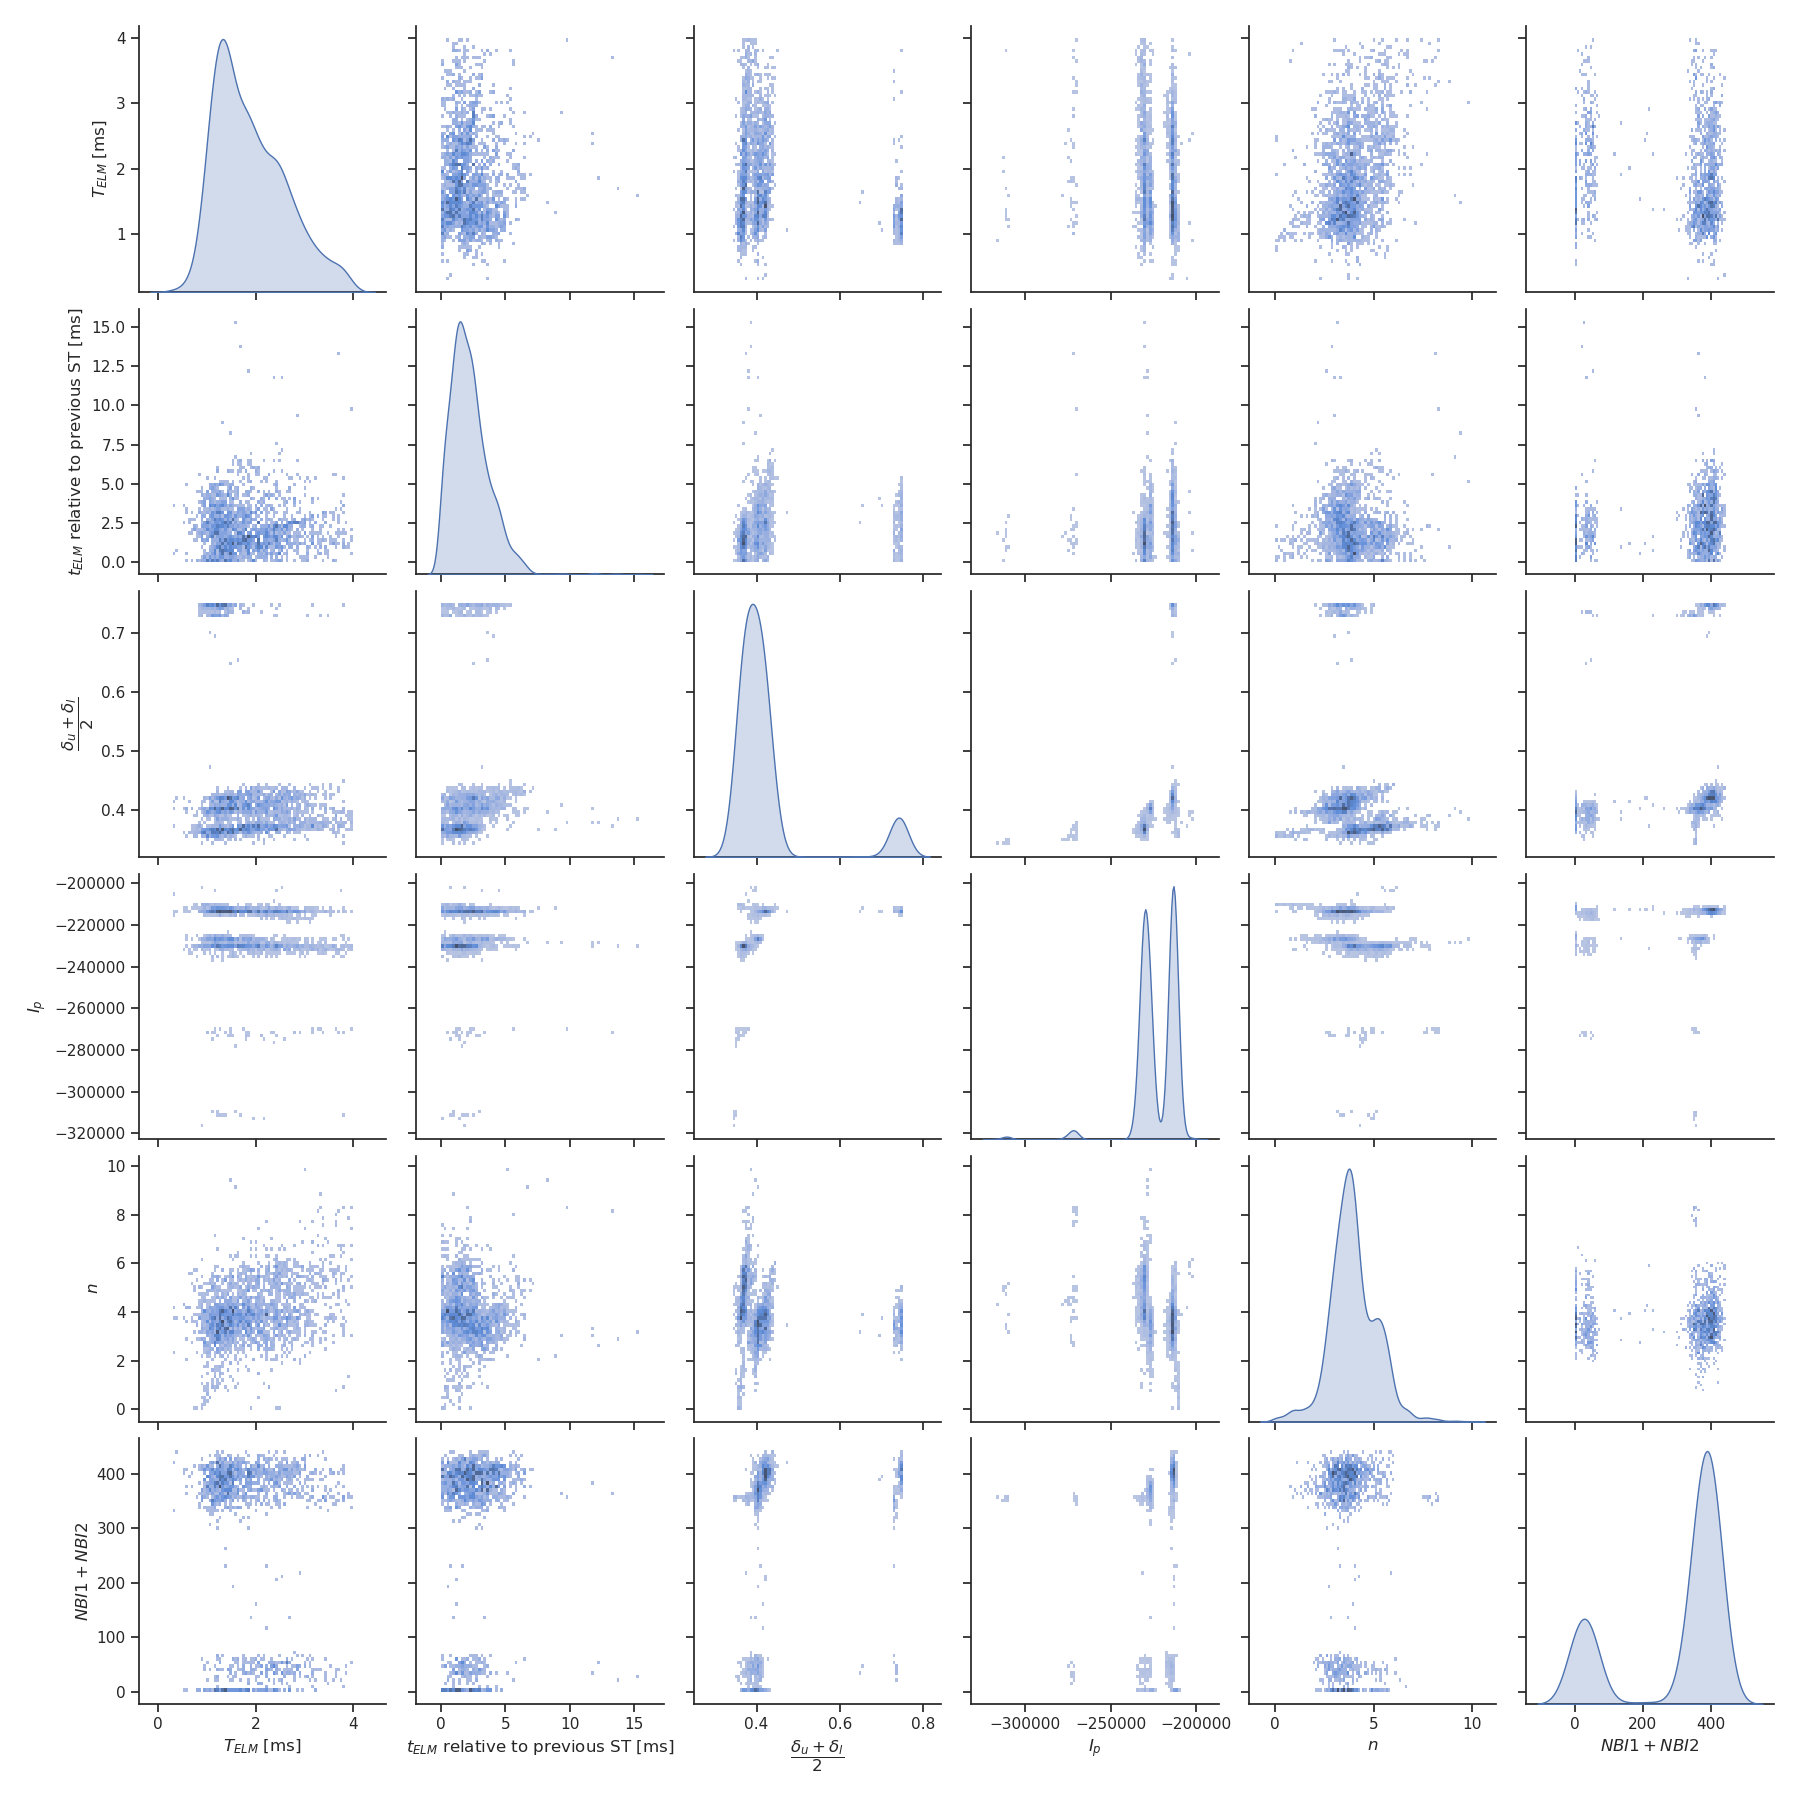

In [164]:
df = pd.DataFrame(data)
sns.set_theme(style="ticks")
hue_variable='$NBI1+NBI2$'

plt.rcParams.update({"figure.dpi": 100})

#sns.pairplot(df,kind="scatter",height=3, aspect=1,diag_kind='kde', plot_kws={'alpha': 0.3,'marker': '.','s': 90,'edgecolor': 'white'},hue=hue_variable, palette='brg',dropna=True)
#sns.pairplot(df,kind="scatter",height=3, aspect=1,diag_kind='kde', plot_kws={'alpha': 0.3,'marker': '.','s': 90,'edgecolor': 'white'},dropna=True)

sns.pairplot(df,kind="hist",height=3, aspect=1,diag_kind='kde',dropna=False, plot_kws={"bins":70,"fill":False})

plt.tight_layout
plt.show()

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import tkinter as tk

# Assuming 'data' is the data you want to visualize
# df = pd.DataFrame(data)

sns.set_theme(style="ticks")

# Set Matplotlib DPI
plt.rcParams.update({"figure.dpi": 100})

# Create a Tkinter GUI
root = tk.Tk()
root.title("Scatter Plot Matrix with Toolbar")

# Specify the variable to use for coloring (hue)
hue_variable = '$I_p$'

# Create a PairGrid for scatter plot matrix
g = sns.PairGrid(df, hue=hue_variable, palette='brg', dropna=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, alpha=0.3, marker='.', s=90, edgecolor='white')

# Add colorbar
g.add_legend()

# Create a Matplotlib FigureCanvasTkAgg
canvas = FigureCanvasTkAgg(g.fig, master=root)
canvas.draw()
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

# Create a NavigationToolbar2Tk
toolbar = NavigationToolbar2Tk(canvas, root)
toolbar.update()
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

# Function to update the scatter plot matrix based on the chosen interval
def update_interval(val):
    interval_start = slider.get()[0]
    interval_end = slider.get()[1]
    
    # Apply the chosen interval to the DataFrame
    df_filtered = df[(df[hue_variable] >= interval_start) & (df[hue_variable] <= interval_end)]

    # Update the PairGrid with the filtered DataFrame
    g.data = df_filtered
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot, alpha=0.3, marker='.', s=90, edgecolor='white')
    
    # Redraw the canvas
    canvas.draw()

# Add a slider for choosing the interval
slider_frame = tk.Frame(root)
slider_frame.pack(side=tk.TOP)
slider = tk.Scale(slider_frame, from_=df[hue_variable].min(), to=df[hue_variable].max(), orient=tk.HORIZONTAL,
                  resolution=0.1, length=200, label="Interval", command=update_interval)
slider.set((df[hue_variable].min(), df[hue_variable].max()))
slider.pack(side=tk.TOP)

# Run the Tkinter main loop
tk.mainloop()


TclError: expected floating-point number but got "-317020.50256054674 -201138.17521289055"

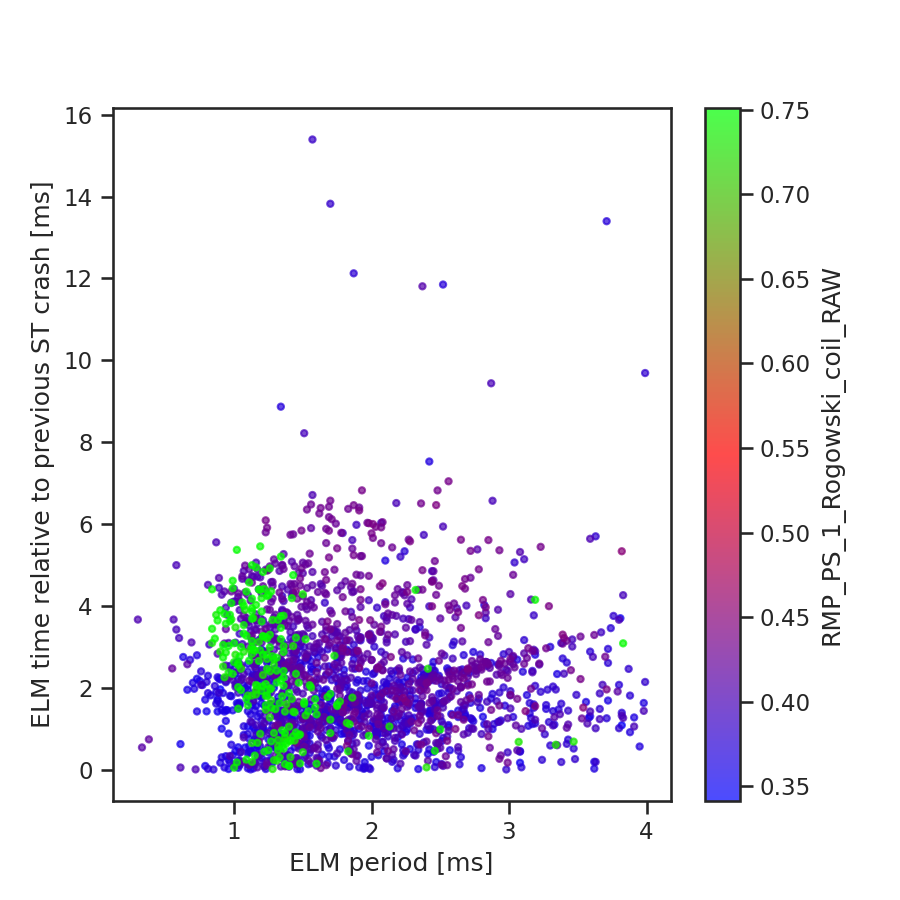

In [42]:
RMP_tot=np.empty(0)
RMP_totx=np.empty(0)

ELM_ST_phase_tot=np.empty(0)
ELM_ST_time_tot=np.empty(0)
ELM_duration_tot=np.empty(0)
triangularity_val=np.empty(0)


for i, d in enumerate(pedestal_data_list):
    
    # if d.shot_number in  range(18350,24000): 
    #     continue
    

    # if 18400<d.shot_number<20151:
    #     continue

    # if 20154<d.shot_number<20180:
    #     continue

    # if 18230<d.shot_number<18250:
    #     continue

    # if d.shot_number in [18252, 18255,18257,18260,18267,18273,18274,18275, 18276,18277,18278,18279,18347, 18360, 18350,21657 ]:
    #     continue


    # if 20199<d.shot_number<28800:
    #     continue

    # if 182<d.shot_number<20180:
    #     continue

    # if d.shot_number in [18252, 18255,18257,18260,18267,18273,18274,18275, 18276,18277,18278,18279 ]:
    #     continue
    
    #print(d.shot_number)

    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)

    # Filters
    shot = cdbxr.Shot(d.shot_number)
    t_ELM_start = shot['t_ELM_start']

    RMP=shot(name="RMP_PS_1_Rogowski_coil_RAW")

    triang_closest_times = t_ELM_start[:-1]
    tria_values1 = shot(name="triangularity_lower_lcfs")
    tria_values2 = shot(name="triangularity_upper_lcfs")
    triangularity = (tria_values1+tria_values2)/2
    triang_closest_times_ints = triang_closest_times.astype(int)
    interpolated_tria_values = triangularity.interp(time=triang_closest_times_ints)
    
    interpolated_RMP_tot = RMP.interp(time=triang_closest_times_ints)

        
    
    mask1 = np.logical_and(0. < ELM_duration, ELM_duration < 4)
    mask2 = np.logical_and(mask1, t_ELM_start[1:] < 1200)

    

    RMP_tot = np.concatenate((RMP_tot,  interpolated_RMP_tot.to_numpy()[mask2]))
    ELM_ST_phase_tot = np.concatenate((ELM_ST_phase_tot, ELM_ST_phase[mask2]))
    ELM_ST_time_tot = np.concatenate((ELM_ST_time_tot, ELM_ST_time[mask2]))
    ELM_duration_tot = np.concatenate((ELM_duration_tot, ELM_duration[mask2]))
    triangularity_val = np.concatenate((triangularity_val, interpolated_tria_values.to_numpy()[mask2]))

    

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6),dpi=150)
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for afrom core.ELM_extraction import ELM_phase square plot.
#gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
#                      left=0.1, right=0.9, bottom=0.1, top=0.9,
#                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot()
plt.xlabel('ELM period [ms]')
plt.ylabel('ELM time relative to previous ST crash [ms]')
# Draw the scatter plot and marginals.
sorting_criterion = triangularity_val

# Sort the data based on the sorting criterion
sorted_indices = np.argsort(sorting_criterion)
sorted_ELM_duration_tot = ELM_duration_tot[sorted_indices]
sorted_ELM_ST_time_tot = ELM_ST_time_tot[sorted_indices]
sorted_triangularity_val = triangularity_val[sorted_indices]


# sorting_criterion = RMP_tot
# sorted_indices = np.argsort(sorting_criterion)
# sorted_ELM_duration_tot = ELM_duration_tot[sorted_indices]
# sorted_ELM_ST_time_tot = ELM_ST_time_tot[sorted_indices]
# sorted_RMP_tot = RMP_tot[sorted_indices]


scatter=ax.scatter(sorted_ELM_duration_tot, sorted_ELM_ST_time_tot,s=9,c=sorted_triangularity_val, alpha=0.7,marker="o", cmap='brg')
#normalize = Normalize(vmin=min(sorted_RMP_tot), vmax=max(sorted_RMP_tot))

#scatter=ax.scatter(sorted_ELM_duration_tot, sorted_ELM_ST_time_tot,s=9,c=sorted_RMP_tot, alpha=0.4 ,marker="o", cmap='brg',vmin=-4000)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'$\dfrac{\delta_u+\delta_l}{2}$')
#cbar.set_label(r'RMP_PS_1_Rogowski_coil_RAW')

18275
19921
18274
18278
19922
18276
18273
18277
19923


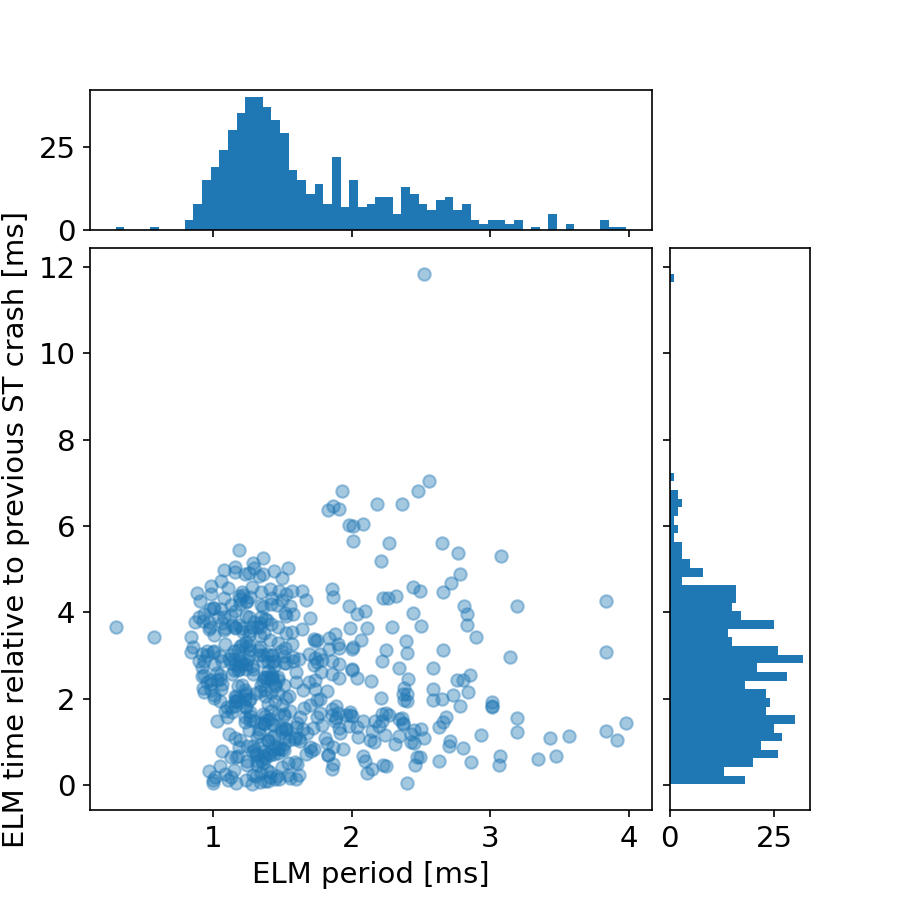

In [ ]:
ELM_ST_phase_tot=np.empty(0)
ELM_ST_time_tot=np.empty(0)
ELM_duration_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
    # if d.shot_number in  range(18350,24000): 
    #     continue


    if 18278<d.shot_number<19921:
        continue

    if 182<d.shot_number<18273:
        continue

    if 19924<d.shot_number<200000:
        continue
    print(d.shot_number)

    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)

    # Filters
    shot = cdbxr.Shot(d.shot_number)
    t_ELM_start = shot['t_ELM_start']
    
    mask1 = np.logical_and(0. < ELM_duration, ELM_duration < 4)
    mask2 = np.logical_and(mask1, t_ELM_start[1:] < 1200)
    
    ELM_ST_phase_tot = np.concatenate((ELM_ST_phase_tot, ELM_ST_phase[mask2]))
    ELM_ST_time_tot = np.concatenate((ELM_ST_time_tot, ELM_ST_time[mask2]))
    ELM_duration_tot = np.concatenate((ELM_duration_tot, ELM_duration[mask2]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6),dpi=150)
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for afrom core.ELM_extraction import ELM_phase square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ELM period [ms]')
plt.ylabel('ELM time relative to previous ST crash [ms]')
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ELM_duration_tot, ELM_ST_time_tot, ax, ax_histx, ax_histy)


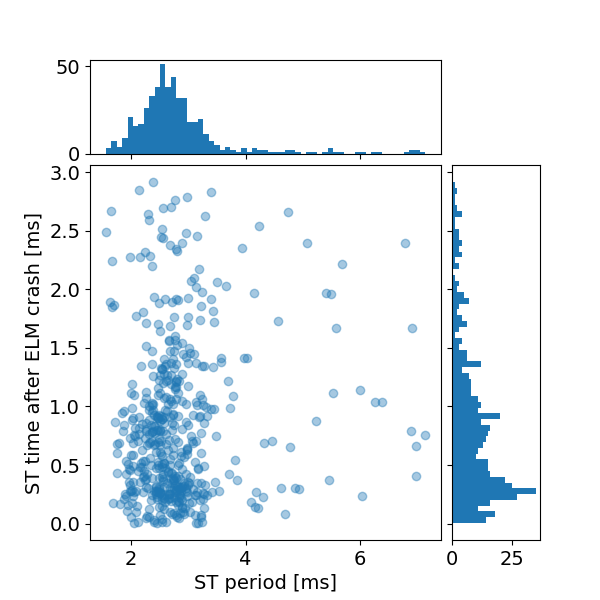

In [227]:
ST_delay_after_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    if 18400<d.shot_number<20151:
        continue

    if 20154<d.shot_number<20180:
        continue

    if 18230<d.shot_number<18250:
        continue

    if d.shot_number in [18252, 18255,18257,18260,18267,18273,18274,18275, 18276,18277,18278,18279,18347, 18360, 18350,21657 ]:
        continue



    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_ELM_phases, ST_delay_after_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times)
    ST_periods = np.diff(ST_times)
    ST_delay_after_ELM = ST_delay_after_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_delay_after_ELM_tot = np.concatenate((ST_delay_after_ELM_tot, ST_delay_after_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6),dpi=100)
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.15, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time after ELM crash [ms]')
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_delay_after_ELM_tot, ax, ax_histx, ax_histy)

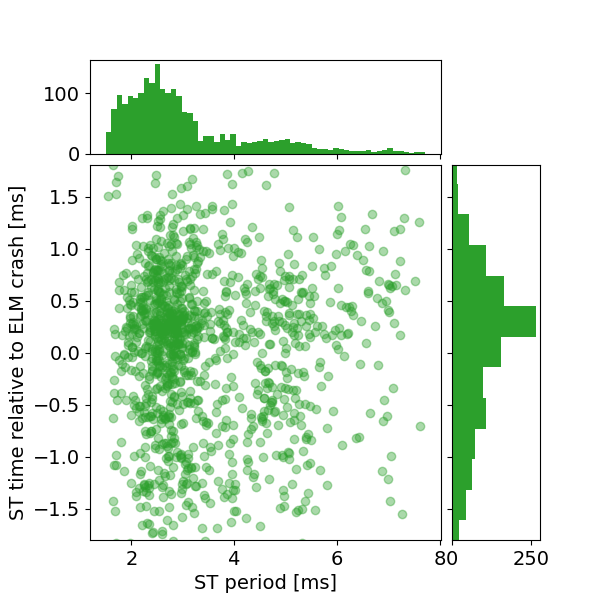

In [ ]:
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.15, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time relative to ELM crash [ms]')
plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_time_relative_to_ELM_tot, ax, ax_histx, ax_histy, c='C2')

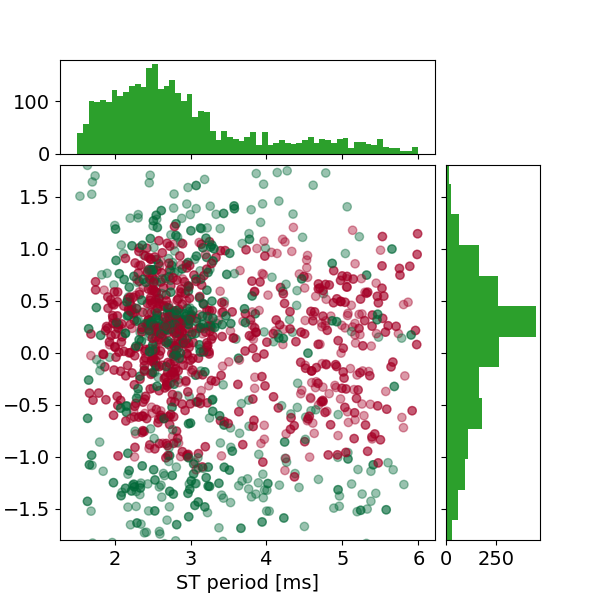

In [ ]:
ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)
elm_duration_tot= np.empty(0)

for i, d in enumerate(pedestal_data_list):
    
#     if d.shot_number in [18257, 18260, 18261, 18263, 18266, 18273, 18277]: #18274, 18275, 
#        continue
    
    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)
    
    ST_times = load_ST_crash_time(d.shot_number)
    ST_phase_in_ELM_period, ST_time_relative_to_ELM, elm_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]
    elm_duration = elm_duration[1:]
    # Filters
    
    mask2 = np.logical_and(0. < ST_periods, ST_periods < 6.)
    #mask2 = np.logical_and(mask1, elm_duration > 2.5)
    
    elm_duration_tot = np.concatenate((elm_duration_tot, elm_duration[mask2]))
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask2]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask2]))

    
elm_duration_tot = np.clip(elm_duration_tot, a_min=2.5, a_max=2.51)
    

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('ST period [ms]')
plt.ylabel('ST time relative to ELM crash [ms]')
plt.ylim((-1.8,1.8))
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(ST_periods_tot, ST_time_relative_to_ELM_tot, ax, ax_histx, ax_histy, c=elm_duration_tot, cmap='RdYlGn')

thrash:

In [17]:
RMP_tot=np.empty(0)

ELM_ST_phase_tot=np.empty(0)
ELM_ST_time_tot=np.empty(0)
ELM_duration_tot=np.empty(0)

triangularity_val=np.empty(0)

ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)


for i, d in enumerate(pedestal_data_list):

    ELM_ST_phase, ELM_duration, ST_amplitudes, ELM_ST_time = get_ELM_ST_phase_and_duration(d.shot_number,load_path=saveped)

    # Filters
    shot = cdbxr.Shot(d.shot_number)
    t_ELM_start = shot['t_ELM_start']

    RMP1=shot(name="RMP_PS_1_Rogowski_coil_RAW")
    RMP2=shot(name="RMP_PS_2_Rogowski_coil_RAW")
    RMP=(abs(RMP1)+abs(RMP2))/2
    triang_closest_times = t_ELM_start[:-1]
    tria_values1 = shot(name="triangularity_lower_lcfs")
    tria_values2 = shot(name="triangularity_upper_lcfs")
    triangularity = (tria_values1+tria_values2)/2
    triang_closest_times_ints = triang_closest_times.astype(int)
    interpolated_tria_values = triangularity.interp(time=triang_closest_times_ints)
    
    interpolated_RMP_tot = RMP.interp(time=triang_closest_times_ints)

        
    
    mask1 = np.logical_and(0. < ELM_duration, ELM_duration < 4)
    mask2 = np.logical_and(mask1, t_ELM_start[1:] < 1200)

    

    RMP_tot = np.concatenate((RMP_tot,  interpolated_RMP_tot.to_numpy()[mask2]))
    ELM_ST_phase_tot = np.concatenate((ELM_ST_phase_tot, ELM_ST_phase[mask2]))
    ELM_ST_time_tot = np.concatenate((ELM_ST_time_tot, ELM_ST_time[mask2]))
    ELM_duration_tot = np.concatenate((ELM_duration_tot, ELM_duration[mask2]))
    triangularity_val = np.concatenate((triangularity_val, interpolated_tria_values.to_numpy()[mask2]))


    ST_times = load_ST_crash_time(d.shot_number)
    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_time_relative_to_ELM[1:]

    # Filters
    
    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)
    
    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_time_relative_to_ELM[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))

    


KeyboardInterrupt: 

In [ ]:
#load the data
# RMP_tot_ST=np.empty(0)

triangularity_val_ST=np.empty(0)

ST_time_relative_to_ELM_tot=np.empty(0)
ST_periods_tot=np.empty(0)


for i, d in enumerate(pedestal_data_list):
    # Filters
    shot = cdbxr.Shot(d.shot_number)
    ST_times = load_ST_crash_time(d.shot_number)

    RMP1=shot(name="RMP_PS_1_Rogowski_coil_RAW")
    RMP2=shot(name="RMP_PS_2_Rogowski_coil_RAW")
    RMP=(abs(RMP1)+abs(RMP2))/2
    
    triang_closest_times = ST_times[:-1]
    tria_values1 = shot(name="triangularity_lower_lcfs")
    tria_values2 = shot(name="triangularity_upper_lcfs")
    triangularity = (tria_values1+tria_values2)/2
    triang_closest_times_ints = triang_closest_times.astype(int)
    interpolated_tria_values = triangularity.interp(time=triang_closest_times_ints)

    # interpolated_RMP_tot = RMP.interp(time=triang_closest_times_ints)


    ST_relative_to_nearest_ELM_phase, ST_time_relative_to_ELM, ELM_duration = ELM_phase(d.shot_number, ST_times, relative_to_nearest=True)
    ST_periods = np.diff(ST_times)
    ST_time_relative_to_ELM = ST_relative_to_nearest_ELM_phase[1:]


    mask1 = np.logical_and(0. < ST_periods, ST_periods < 8.)
    #mask2 = np.logical_and(mask1, ST_delay_after_ELM < 3)


    #RMP_tot_ST = np.concatenate((RMP_tot_ST,  interpolated_RMP_tot.to_numpy()[mask1]))
    triangularity_val_ST = np.concatenate((triangularity_val_ST, interpolated_tria_values.to_numpy()[mask1]))

    ST_time_relative_to_ELM_tot = np.concatenate((ST_time_relative_to_ELM_tot, ST_relative_to_nearest_ELM_phase[mask1]))
    ST_periods_tot = np.concatenate((ST_periods_tot, ST_periods[mask1]))

    


IndexError: boolean index did not match indexed array along dimension 0; dimension is 38 but corresponding boolean dimension is 37